#### Training model to predict arrived delay on flights
Using Logistic Regression for binary classification

##### Loading database

In [1]:
import pandas as pd

database = pd.read_csv('airports-database.csv')

In [2]:
database.head()

,id,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,...,flight,tailnum,origin,dest,air_time,distance,hour,minute,time_hour,name
0,0,2013,1,1,517.0,515,2.0,830.0,819,11.0,...,1545,N14228,EWR,IAH,227.0,1400,5,15,2013-01-01 05:00:00,United Air Lines Inc.
1,1,2013,1,1,533.0,529,4.0,850.0,830,20.0,...,1714,N24211,LGA,IAH,227.0,1416,5,29,2013-01-01 05:00:00,United Air Lines Inc.
2,2,2013,1,1,542.0,540,2.0,923.0,850,33.0,...,1141,N619AA,JFK,MIA,160.0,1089,5,40,2013-01-01 05:00:00,American Airlines Inc.
3,3,2013,1,1,544.0,545,-1.0,1004.0,1022,-18.0,...,725,N804JB,JFK,BQN,183.0,1576,5,45,2013-01-01 05:00:00,JetBlue Airways
4,4,2013,1,1,554.0,600,-6.0,812.0,837,-25.0,...,461,N668DN,LGA,ATL,116.0,762,6,0,2013-01-01 06:00:00,Delta Air Lines Inc.


In [3]:
database.dtypes

id                  int64
year                int64
month               int64
day                 int64
dep_time          float64
sched_dep_time      int64
dep_delay         float64
arr_time          float64
sched_arr_time      int64
arr_delay         float64
carrier            object
flight              int64
tailnum            object
origin             object
dest               object
air_time          float64
distance            int64
hour                int64
minute              int64
time_hour          object
name               object
dtype: object

###### Preprocessing data

In [4]:
database.isnull().sum()

#trataremos os nulos na pipeline

id                   0
year                 0
month                0
day                  0
dep_time          8255
sched_dep_time       0
dep_delay         8255
arr_time          8713
sched_arr_time       0
arr_delay         9430
carrier              0
flight               0
tailnum           2512
origin               0
dest                 0
air_time          9430
distance             0
hour                 0
minute               0
time_hour            0
name                 0
dtype: int64

In [5]:
database.count()

id                336776
year              336776
month             336776
day               336776
dep_time          328521
sched_dep_time    336776
dep_delay         328521
arr_time          328063
sched_arr_time    336776
arr_delay         327346
carrier           336776
flight            336776
tailnum           334264
origin            336776
dest              336776
air_time          327346
distance          336776
hour              336776
minute            336776
time_hour         336776
name              336776
dtype: int64

In [8]:
# select columns that will be used on model
database_selected_features = database[["tailnum","carrier","origin","dest","name","distance","arr_delay"]]

In [ ]:
#convert types
database_selected_features['arr_delay'] = database_selected_features['arr_delay'].astype(float)
database_selected_features['distance'] = database_selected_features['distance'].astype(int)

In [10]:
database_selected_features.dtypes

tailnum       object
carrier       object
origin        object
dest          object
name          object
distance       int64
arr_delay    float64
dtype: object

In [11]:
display(database_selected_features)

,tailnum,carrier,origin,dest,name,distance,arr_delay
0,N14228,UA,EWR,IAH,United Air Lines Inc.,1400,11.0
1,N24211,UA,LGA,IAH,United Air Lines Inc.,1416,20.0
2,N619AA,AA,JFK,MIA,American Airlines Inc.,1089,33.0
3,N804JB,B6,JFK,BQN,JetBlue Airways,1576,-18.0
4,N668DN,DL,LGA,ATL,Delta Air Lines Inc.,762,-25.0
...,...,...,...,...,...,...,...
336771,NaN,9E,JFK,DCA,Endeavor Air Inc.,213,NaN
336772,NaN,9E,LGA,SYR,Endeavor Air Inc.,198,NaN
336773,N535MQ,MQ,LGA,BNA,Envoy Air,764,NaN
336774,N511MQ,MQ,LGA,CLE,Envoy Air,419,NaN


In [ ]:
import numpy as np

#transform our target column into category
database_selected_features['target'] = np.where(database_selected_features["arr_delay"]>0, 1, 0)

y = database_selected_features["target"]
X = database_selected_features.drop(columns=["arr_delay","target"],axis=1)

In [13]:
X.shape

(336776, 6)

In [14]:
y.shape

(336776,)

In [15]:
X.head()

,tailnum,carrier,origin,dest,name,distance
0,N14228,UA,EWR,IAH,United Air Lines Inc.,1400
1,N24211,UA,LGA,IAH,United Air Lines Inc.,1416
2,N619AA,AA,JFK,MIA,American Airlines Inc.,1089
3,N804JB,B6,JFK,BQN,JetBlue Airways,1576
4,N668DN,DL,LGA,ATL,Delta Air Lines Inc.,762


In [16]:
y.head()

0    1
1    1
2    1
3    0
4    0
Name: target, dtype: int64

In [17]:
from sklearn.model_selection import train_test_split

#split train test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

#### Training model

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from category_encoders import CatBoostEncoder
from sklearn.linear_model import LogisticRegression

numeric_features = ['distance']

numeric_transformer = Pipeline(steps=[
     ('imputer', SimpleImputer(strategy='median')),
     ('scaler', StandardScaler())])

categorical_features = ['tailnum','carrier','origin','dest','name']

categorical_transformer = Pipeline(steps=[ 
     ('imputer', SimpleImputer(strategy='constant',fill_value=0)),
     ('encoder', CatBoostEncoder())])

preprocessor = ColumnTransformer(
     transformers=[
          ('num', numeric_transformer, numeric_features),
          ('cat', categorical_transformer, categorical_features)])

# Now join together the preprocessing with the classifier.
pipeline_svc = Pipeline(steps=[('preprocessor', preprocessor),
     ('classifier', LogisticRegression())], verbose=True)
#fit the pipeline
pipeline_svc.fit(X_train, y_train)

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   1.7s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   1.0s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['distance']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   CatBoostEncoder())]),
                                                  ['tailnum', 'carrier',
                                                   'origin', 'dest',
                                                   'name'])])),
                ('classifier', LogisticRegression())],
         verbose=True)

##### Model evaluation and log with mlflow

In [25]:
from sklearn.metrics import roc_curve, roc_auc_score, classification_report
from sklearn.model_selection import cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt

def avalia_modelo_classificacao(modelo,x_train,y_train,x_test,y_test):
    # Fazendo previsões de probabilidades para o conjunto de teste e de treino
    prob_predic_test = modelo.predict_proba(x_test)
    prob_predic_train = modelo.predict_proba(x_train)

    y_pred_probs_test = prob_predic_test[:, 1]
    y_pred_probs_train = prob_predic_train[:, 1]

    print(f"\n------------------------------Resultados {modelo}------------------------------\n")

    # Calculando a AUC (área sob a curva ROC) para o conjunto de teste e treino
    auc_test = roc_auc_score(y_test, y_pred_probs_test)
    auc_train = roc_auc_score(y_train, y_pred_probs_train)
    print(f"AUC (Teste) {auc_test:.2f}")
    print(f"AUC (Treino) {auc_train:.2f}")
    mlflow.log_metric("AUC_teste",auc_test)
    mlflow.log_metric("AUC_treino",auc_train)

    # Fazendo a predição dos dados de teste e calculando o classification report
    predicao = modelo.predict(x_test)
    print("\nClassification Report")
    print(classification_report(y_test, predicao, zero_division=0))
    mlflow.log_text(str(classification_report(y_test, predicao, zero_division=0)), f"model/classification_report.txt")

    print("\nRoc Curve\n")
    # Calcular a curva ROC para o conjunto de teste e treino
    fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_probs_test)
    fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_probs_train)

    # Plotar a curva ROC para o conjunto de teste e treino
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_test, tpr_test, color='blue', lw=2, label=f'ROC curve Teste (AUC = {auc_test:.2f})')
    plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve Treino (AUC = {auc_train:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falso Positivo')
    plt.ylabel('Taxa de Verdadeiro Positivo')
    plt.title('Curva ROC para Conjuntos de Treino e Teste')
    plt.legend(loc='lower right')
    plt.show()
    mlflow.log_figure(plt.figure(figsize=(8, 6)), "model/curva_roc.png")


/home/raiane/Documentos/Projetos/.venv/lib/python3.10/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(



------------------------------Resultados Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['distance']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                              

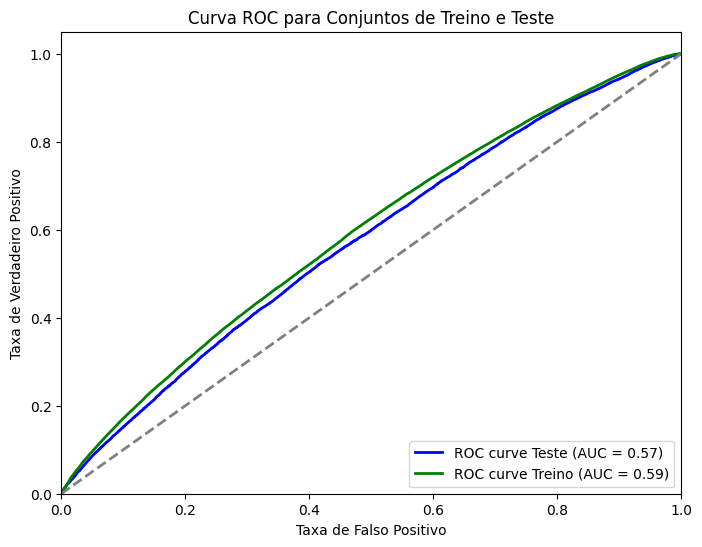

Active run_id: 47ed45db4cef4fe7a7aa78cb5f6b4934


<Figure size 800x600 with 0 Axes>

In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature

with mlflow.start_run():
     y_pred = pipeline_svc.predict(X_test)
     signature = infer_signature(X_test, y_pred)
     input_example = X_test.head(5)
     # log model
     mlflow.sklearn.log_model(
          artifact_path="model",
          sk_model=pipeline_svc,
          signature=signature,
          input_example=input_example
          )
     #evaluation and log metrics
     avalia_modelo_classificacao(pipeline_svc, X_train, y_train, X_test, y_test)
     #print out the active run ID
     run = mlflow.active_run()
     print("Active run_id: {}".format(run.info.run_id))